In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [2]:
MODEL_NAME = "bert-base-multilingual-cased"

DATASET_NAME = "MonoHime/ru_sentiment_dataset"
TEXT_COL = "text"
LABEL_COL = "sentiment"

MAX_LENGTH = 128
BATCH_SIZE = 32

MAX_TRAIN_SAMPLES = 8000
MAX_VALID_SAMPLES = 2000
MAX_TEST_SAMPLES = 3000

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
ds = load_dataset(DATASET_NAME)
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/276M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/32.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/189891 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21098 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
from datasets import load_dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
import numpy as np

print("Available splits:", list(ds.keys()))
print("Label feature BEFORE:", ds["train"].features[LABEL_COL])

# Make sure labels are 0..K-1 and cast to ClassLabel (для всех сплитов)
label_values = sorted(set(ds["train"][LABEL_COL]))
value_to_id = {v: i for i, v in enumerate(label_values)}


def encode_labels(ex):
    ex[LABEL_COL] = value_to_id[ex[LABEL_COL]]
    return ex


ds = ds.map(encode_labels)

label_feature = ClassLabel(
    num_classes=len(label_values),
    names=[str(v) for v in label_values]
)

ds = DatasetDict({k: v.cast_column(LABEL_COL, label_feature) for k, v in ds.items()})
print("Label feature AFTER:", ds["train"].features[LABEL_COL])

# Build train/valid split from train (stratified)
split = ds["train"].train_test_split(
    test_size=0.2,
    seed=SEED,
    stratify_by_column=LABEL_COL
)
train_full = split["train"]
valid_full = split["test"]

# Choose test split (если нет test — берём validation/valid)
if "test" in ds:
    test_full = ds["test"]
elif "validation" in ds:
    test_full = ds["validation"]
elif "valid" in ds:
    test_full = ds["valid"]
else:
    test_full = valid_full  # fallback

# Convert to python lists
train_texts, train_labels = list(train_full[TEXT_COL]), list(train_full[LABEL_COL])
valid_texts, valid_labels = list(valid_full[TEXT_COL]), list(valid_full[LABEL_COL])
test_texts, test_labels = list(test_full[TEXT_COL]), list(test_full[LABEL_COL])


# Optional subsampling (to make it faster)
def maybe_subsample(texts, labels, max_n, seed=SEED):
    if max_n is None or len(texts) <= max_n:
        return texts, labels
    rng = np.random.default_rng(seed)
    sel = rng.choice(len(texts), size=max_n, replace=False).tolist()
    return [texts[i] for i in sel], [labels[i] for i in sel]


train_texts, train_labels = maybe_subsample(train_texts, train_labels, MAX_TRAIN_SAMPLES)
valid_texts, valid_labels = maybe_subsample(valid_texts, valid_labels, MAX_VALID_SAMPLES)
test_texts, test_labels = maybe_subsample(test_texts, test_labels, MAX_TEST_SAMPLES)

print("Final sizes:", len(train_texts), len(valid_texts), len(test_texts))
print("Label ids in train:", sorted(set(train_labels)))

Available splits: ['train', 'validation']
Label feature BEFORE: Value('int64')


Map:   0%|          | 0/189891 [00:00<?, ? examples/s]

Map:   0%|          | 0/21098 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/189891 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/21098 [00:00<?, ? examples/s]

Label feature AFTER: ClassLabel(names=['0', '1', '2'])
Final sizes: 8000 2000 3000
Label ids in train: [0, 1, 2]


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize_batch(text_list):
    return tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )


class SimpleTextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        return self.texts[i], int(self.labels[i])


def collate_fn(batch):
    texts, labels = zip(*batch)
    enc = tokenize_batch(list(texts))
    enc["labels"] = torch.tensor(labels, dtype=torch.long)
    return enc


train_loader = DataLoader(SimpleTextDataset(train_texts, train_labels), batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate_fn)
valid_loader = DataLoader(SimpleTextDataset(valid_texts, valid_labels), batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate_fn)
test_loader = DataLoader(SimpleTextDataset(test_texts, test_labels), batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn)

next(iter(train_loader)).keys()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

KeysView({'input_ids': tensor([[   101,  19196,  10783,  ...,  12528,  40181,    102],
        [   101, 102355,    558,  ...,  52629,  10783,    102],
        [   101,    519,  75714,  ...,      0,      0,      0],
        ...,
        [   101,    514,  21657,  ...,  31851,  10587,    102],
        [   101,    510,  54869,  ...,  12999,  10375,    102],
        [   101,  19196,  17371,  ...,      0,      0,      0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([2, 2, 2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 

In [8]:
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()

# Узнаём число слоёв: hidden_states = [embeddings] + [layer1..layerL]
with torch.no_grad():
    b = next(iter(train_loader))
    out = model(
        input_ids=b["input_ids"].to(DEVICE),
        attention_mask=b["attention_mask"].to(DEVICE),
        output_hidden_states=True,
        return_dict=True
    )
n_layers_total = len(out.hidden_states)  # L+1
hidden_dim = out.hidden_states[0].shape[-1]
n_layers_total, hidden_dim

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

(13, 768)

In [9]:
@torch.no_grad()
def extract_layer_features(dataloader, layer_idx: int, pooling: str = "cls"):
    """
    layer_idx: 0..L (0=embeddings, L=последний трансформерный слой)
    pooling: 'cls' (берём hidden[:,0,:]) или 'mean' (mean pooling с mask)
    """
    feats = []
    ys = []

    for batch in tqdm(dataloader, desc=f"Extract layer {layer_idx}", leave=False):
        input_ids = batch["input_ids"].to(DEVICE)
        attn = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].cpu().numpy()

        out = model(input_ids=input_ids, attention_mask=attn, output_hidden_states=True, return_dict=True)
        h = out.hidden_states[layer_idx]  # [B, T, H]

        if pooling == "cls":
            x = h[:, 0, :]  # [B, H]
        elif pooling == "mean":
            mask = attn.unsqueeze(-1)  # [B, T, 1]
            summed = (h * mask).sum(dim=1)
            denom = mask.sum(dim=1).clamp(min=1)
            x = summed / denom
        else:
            raise ValueError("pooling must be 'cls' or 'mean'")

        feats.append(x.detach().cpu().numpy().astype(np.float32))
        ys.append(labels)

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(ys, axis=0)
    return X, y

In [10]:
def train_eval_probe(X_train, y_train, X_valid, y_valid):
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            max_iter=2000,
            n_jobs=None,
            class_weight="balanced",
            solver="lbfgs",
            multi_class="auto"
        ))
    ])
    clf.fit(X_train, y_train)
    pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1m = f1_score(y_valid, pred, average="macro")
    return acc, f1m, clf


results = []
all_clfs = {}

POOLING = "cls"

for layer_idx in range(n_layers_total):
    Xtr, ytr = extract_layer_features(train_loader, layer_idx, pooling=POOLING)
    Xva, yva = extract_layer_features(valid_loader, layer_idx, pooling=POOLING)

    acc, f1m, clf = train_eval_probe(Xtr, ytr, Xva, yva)
    results.append({"layer": layer_idx, "acc_valid": acc, "f1_macro_valid": f1m})
    all_clfs[layer_idx] = clf

df = pd.DataFrame(results).sort_values("layer")
df.head(), df.tail()

Extract layer 0:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 0:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 1:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 1:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 2:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 2:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 3:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 3:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 4:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 4:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 5:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 5:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 6:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 6:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 7:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 7:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 8:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 8:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 9:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 9:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 10:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 10:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 11:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 11:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 12:   0%|          | 0/250 [00:00<?, ?it/s]

Extract layer 12:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(   layer  acc_valid  f1_macro_valid
 0      0     0.2695        0.141526
 1      1     0.6150        0.612550
 2      2     0.6150        0.608766
 3      3     0.6250        0.620369
 4      4     0.6335        0.629729,
     layer  acc_valid  f1_macro_valid
 8       8     0.6200        0.616093
 9       9     0.6260        0.621442
 10     10     0.6110        0.606985
 11     11     0.6235        0.619397
 12     12     0.6220        0.618907)

## Анализ результатов по слоям (VALID)

Сравним качество простого probe-классификатора (LogReg) на представлениях разных слоёв `bert-base-multilingual-cased` при pooling=`cls`.
Главная идея: если метка (тональность) линейно читается из эмбеддингов слоя, то probe даст высокий Accuracy / Macro-F1.

### Ключевые наблюдения
- **Слой 0 (embeddings) — худший.**
  Он даёт acc≈0.27 и macro-F1≈0.14.
  Это ожидаемо: embeddings почти не содержат контекста (нет учёта отрицаний, усилителей, структуры фразы), поэтому тональность плохо отделима.

- **Резкий скачок качества уже на слое 1.**
  Сразу после первого Transformer-блока метрики поднимаются примерно к ~0.61 (и accuracy, и macro-F1).
  Это означает: даже один блок резко добавляет контекстуализацию, и сигнал тональности становится “читаемым”.

- **Пик информативности — в середине сети.**
  Лучшие значения на VALID достигаются в зоне слоёв 4–5, максимум — на слое 5:
  - layer 5: `acc_valid=0.6380`, `f1_macro_valid=0.632807`
  - layer 4: `acc_valid=0.6335`, `f1_macro_valid=0.629729`
  Это поддерживает гипотезу, что самые полезные признаки часто в промежуточных слоях.

- **Дальше идёт плато (слои 6–12) с небольшими колебаниями.**
  Метрики остаются примерно в диапазоне ~0.60–0.62, без существенного роста.
  То есть поздние слои не дают явного выигрыша для линейного probe на этой задаче.

Macro-F1 учитывает каждый класс равновесно и более чувствителен к ошибкам на редких классах.
То, что accuracy и macro-F1 согласованы (оба максимальны на слое 5), говорит: улучшение не за счёт угадывания одного доминирующего класса.

,layer,acc_valid,f1_macro_valid
0,0,0.2695,0.141526
1,1,0.6150,0.612550
2,2,0.6150,0.608766
3,3,0.6250,0.620369
4,4,0.6335,0.629729
5,5,0.6380,0.632807
6,6,0.6215,0.618666
7,7,0.6015,0.597690
8,8,0.6200,0.616093
9,9,0.6260,0.621442


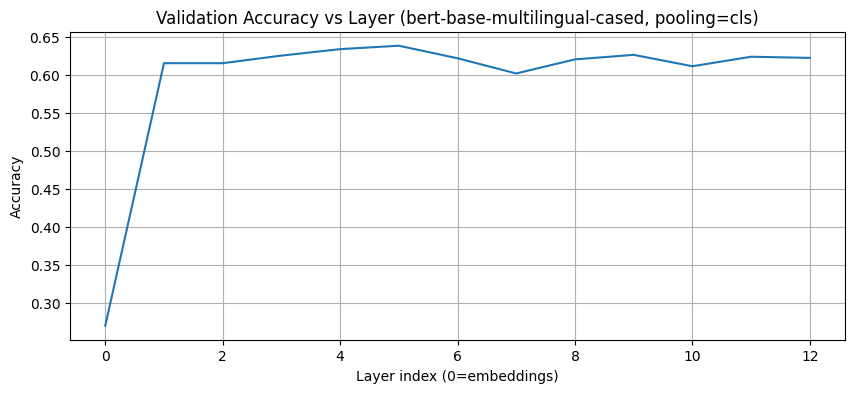

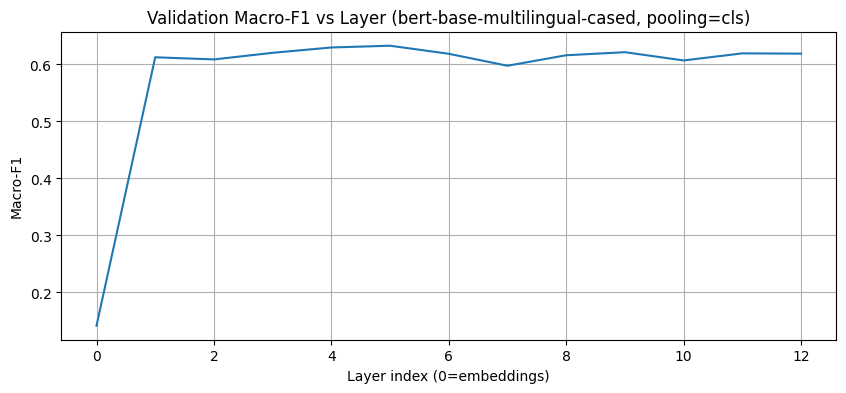

In [11]:
display(df)

plt.figure(figsize=(10, 4))
plt.plot(df["layer"], df["acc_valid"])
plt.title(f"Validation Accuracy vs Layer ({MODEL_NAME}, pooling={POOLING})")
plt.xlabel("Layer index (0=embeddings)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df["layer"], df["f1_macro_valid"])
plt.title(f"Validation Macro-F1 vs Layer ({MODEL_NAME}, pooling={POOLING})")
plt.xlabel("Layer index (0=embeddings)")
plt.ylabel("Macro-F1")
plt.grid(True)
plt.show()

Графики показывают типичную структуру распределения информации по слоям:

1) Слой 0 сильно отстаёт, затем происходит скачок на слое 1.
   Это подтверждает, что сырые embeddings практически не пригодны для тональности без контекста.

2) Максимум в середине (слой 5) и далее “плато”.
   Это важный эмпирический результат: признаки для тональности лучше всего извлекаются не из финальных слоёв, а из промежуточных.

3) Небольшие просадки/колебания (например около слоя 7) — нормальны.
   Разные слои могут усиливать разные типы информации (лексика/синтаксис/семантика), и не обязаны монотонно улучшать разделимость именно для sentiment-классов.


In [12]:
top3 = df.sort_values("f1_macro_valid", ascending=False).head(3).copy()
top3_layers = top3["layer"].tolist()
top3

,layer,acc_valid,f1_macro_valid
5,5,0.6380,0.632807
4,4,0.6335,0.629729
9,9,0.6260,0.621442


## Top-3 слоя по VALID Macro-F1

Мы выбираем top-3 слоя по `f1_macro_valid`, чтобы:
- подтвердить зону максимума,
- потом честно проверить их на тесте.

Получилось:

1) layer 5 — лучший: `acc=0.6380`, `macro-F1=0.632807`
2) layer 4 — очень близко: `acc=0.6335`, `macro-F1=0.629729`
3) layer 9 — заметно ниже: `acc=0.6260`, `macro-F1=0.621442`

Интерпретация:
- слои 4–5 — реальная вершина для этой задачи и pooling=`cls`;
- слой 9 остаётся конкурентным, но уже уступает промежуточным слоям.
Это дополнительно подтверждает тезис: наиболее информативные признаки сосредоточены в середине сети.


In [13]:
test_results = []

# Чтобы честно: обучим probe заново на (train+valid), и проверим на test
trainval_texts = train_texts + valid_texts
trainval_labels = train_labels + valid_labels
trainval_loader = DataLoader(SimpleTextDataset(trainval_texts, trainval_labels), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

for layer_idx in top3_layers:
    Xtr, ytr = extract_layer_features(trainval_loader, layer_idx, pooling=POOLING)
    Xte, yte = extract_layer_features(test_loader, layer_idx, pooling=POOLING)

    acc, f1m, _ = train_eval_probe(Xtr, ytr, Xte, yte)
    test_results.append({"layer": layer_idx, "acc_test": acc, "f1_macro_test": f1m})

df_top3_test = pd.DataFrame(test_results).sort_values("f1_macro_test", ascending=False)
df_top3_test

Extract layer 5:   0%|          | 0/313 [00:00<?, ?it/s]

Extract layer 5:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 4:   0%|          | 0/313 [00:00<?, ?it/s]

Extract layer 4:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Extract layer 9:   0%|          | 0/313 [00:00<?, ?it/s]

Extract layer 9:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,layer,acc_test,f1_macro_test
0,5,0.632000,0.629781
1,4,0.626333,0.622658
2,9,0.620333,0.619137


In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsne_plot_for_layer(layer_idx, loader, title, max_points=1200):
    X, y = extract_layer_features(loader, layer_idx, pooling=POOLING)

    if len(X) > max_points:
        rng = np.random.default_rng(SEED)
        sel = rng.choice(len(X), size=max_points, replace=False)
        X, y = X[sel], y[sel]

    # PCA для ускорения t-SNE
    pca = PCA(n_components=min(50, X.shape[1]), random_state=SEED)
    Xp = pca.fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
    Xt = tsne.fit_transform(Xp)

    plt.figure(figsize=(7, 6))
    plt.scatter(Xt[:, 0], Xt[:, 1], c=y, s=8)
    plt.title(title)
    plt.axis("off")
    plt.show()

best_layer = int(df.sort_values("f1_macro_valid", ascending=False).iloc[0]["layer"])
worst_layer = int(df.sort_values("f1_macro_valid", ascending=True).iloc[0]["layer"])

best_layer, worst_layer

(5, 0)

Extract layer 5:   0%|          | 0/63 [00:00<?, ?it/s]

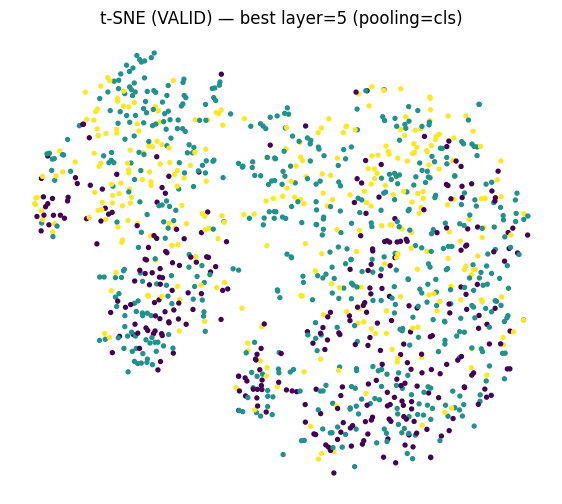

Extract layer 0:   0%|          | 0/63 [00:00<?, ?it/s]

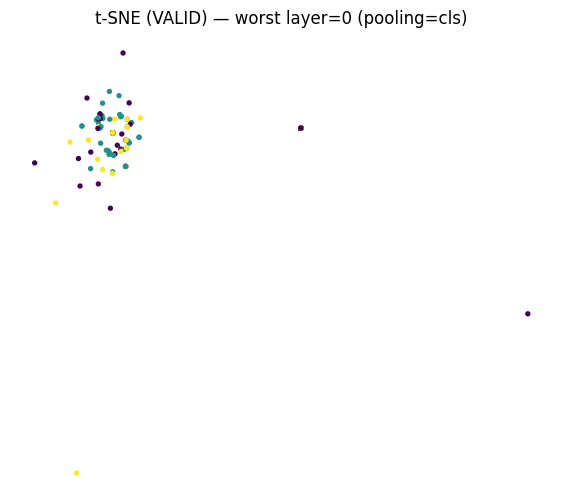

In [15]:
tsne_plot_for_layer(best_layer, valid_loader, f"t-SNE (VALID) — best layer={best_layer} (pooling={POOLING})")
tsne_plot_for_layer(worst_layer, valid_loader, f"t-SNE (VALID) — worst layer={worst_layer} (pooling={POOLING})")

## t-SNE (VALID) — худший слой 0

На t-SNE для layer 0 видно:
- большинство точек сжато в маленькое облако,
- классы (цвета) сильно перемешаны,
- присутствуют выбросы.

Интерпретация:
- слой 0 отражает в основном сырые токенно-позиционные признаки без полноценного контекста;
- геометрия пространства почти не организована по тональности → линейный probe не может отделять классы, что соответствует очень низкому Macro-F1.
- выбросы часто появляются из-за редких токенов/нестандартных примеров и не формируют осмысимые кластеры по меткам.


## t-SNE (VALID) — лучший слой 5

На t-SNE для layer 5 видно:
- пространство стало гораздо более структурированным (много областей/локальных островков),
- облако развёрнуто и богаче по форме по сравнению со слоем 0,
- при этом классы всё ещё частично смешаны.

Почему смешение не противоречит Macro-F1≈0.63:
- t-SNE — нелинейная 2D-проекция: она сохраняет локальные соседства, но не обязана показывать глобальную разделимость, существующую в 768D;
- тональность часто не образует 3 идеально раздельных кластера, а распределяется как градиент по семантике;
- важный факт: по сравнению со слоем 0 на слое 5 появляется выраженная структура — это визуально согласуется с ростом качества probe.

Вывод по t-SNE: визуализация поддерживает метрики — слой 5 действительно несёт более информативные признаки, чем слой 0.


In [16]:
print("=== Итоги по слоям (VALID) ===")
print(df.sort_values("f1_macro_valid", ascending=False).head(8).to_string(index=False))

print("\n=== Top-3 слоёв по VALID Macro-F1 ===")
print(top3.to_string(index=False))

print("\n=== Test на top-3 (обучение на train+valid) ===")
print(df_top3_test.to_string(index=False))

print("\nИнтерпретация (типично для трансформеров):")
print("- Ранние слои ближе к лексико-символьным/морфологическим признакам;")
print("- Промежуточные слои часто дают наиболее 'универсальные' семантические представления для линейного пробника;")
print("- Последние слои могут быть более 'заточены' под pretraining-цели (MLM) и иногда становятся менее линейно-разделимыми для прикладной задачи.")
print("\nПроверьте по графику: если пик Macro-F1 в середине — это подтверждает гипотезу про информативность промежуточных слоёв.")

=== Итоги по слоям (VALID) ===
 layer  acc_valid  f1_macro_valid
     5     0.6380        0.632807
     4     0.6335        0.629729
     9     0.6260        0.621442
     3     0.6250        0.620369
    11     0.6235        0.619397
    12     0.6220        0.618907
     6     0.6215        0.618666
     8     0.6200        0.616093

=== Top-3 слоёв по VALID Macro-F1 ===
 layer  acc_valid  f1_macro_valid
     5     0.6380        0.632807
     4     0.6335        0.629729
     9     0.6260        0.621442

=== Test на top-3 (обучение на train+valid) ===
 layer  acc_test  f1_macro_test
     5  0.632000       0.629781
     4  0.626333       0.622658
     9  0.620333       0.619137

Интерпретация (типично для трансформеров):
- Ранние слои ближе к лексико-символьным/морфологическим признакам;
- Промежуточные слои часто дают наиболее 'универсальные' семантические представления для линейного пробника;
- Последние слои могут быть более 'заточены' под pretraining-цели (MLM) и иногда становятс

## Проверка обобщающей способности: train+valid → test

После выбора слоя на VALID чтобы не переоценить результат мы переобучаем probe на объединении train+valid и оцениваем на независимом test.

Результаты:

- layer 5: `acc_test=0.632000`, `macro-F1_test=0.629781`
- layer 4: `acc_test=0.626333`, `macro-F1_test=0.622658`
- layer 9: `acc_test=0.620333`, `macro-F1_test=0.619137`

Что важно:
- Порядок сохраняется (5 > 4 > 9) → выбор лучшего слоя устойчивый, а не подогнанный под валидацию.
- Значения на тесте близки к валидации → нет сильного переобучения probe.
- Разница между 5 и 4 небольшая, но стабильная → пик действительно в районе 4–5, а не случайно на одном слое.

Итог: слой 5 не только лучший на VALID, но и лучше всего обобщается на TEST в сравнении с соседними кандидатами.



## Итог

1) Embeddings (layer 0) не подходят для sentiment-классификации: метрики почти на уровне плохого baseline.
2) Контекстуализация появляется очень рано (layer 1 резко лучше).
3) Наиболее информативные признаки — в середине сети, лучший слой: 5 (и на VALID, и на TEST).
4) Поздние слои дают плато качества и не превосходят пик в середине.
5) t-SNE качественно подтверждает метрики: best слой даёт более структурированное пространство признаков, чем worst слой.
